In [2]:
%matplotlib inline

In [1]:
import sys
import os
import pandas as pd
import xarray as xr
from scipy.io import loadmat
import numpy as np
import scipy.optimize
from sklearn import linear_model

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, save
from bokeh.io import reset_output
import bokeh

In [3]:
# ============================================================ #
# Parameters
# ============================================================ #
start_date = pd.datetime.strptime("1980-01-01", "%Y-%m-%d")
end_date = pd.datetime.strptime("1989-12-31", "%Y-%m-%d")
start_year = start_date.year
end_year = end_date.year
window_size = 3

In [4]:
# ============================================================ #
# Load original and true prec data
# ============================================================ #
print('Loading data...')

# --- Load original prec (to be corrected) --- #
mat_smart_input = 'SMART_input_one_cell.mat'
dict_smart_input = loadmat(mat_smart_input)

# --- Load original prec --- #
prec_orig = dict_smart_input['prec_orig']  # [cell, day]

# --- Load true prec --- #
prec_true = dict_smart_input['prec_true']  # [cell, day]

Loading data...


In [5]:
# --- Load SMART-corrected prec ensemble mean --- #
mat_prec_corr = './output/SMART_corrected_rainfall.mat'
prec_corr = loadmat(mat_prec_corr)['RAIN_SMART_SMOS']  # [window, grid_cell]

In [6]:
# --- Load lambda --- #
mat_lambda = './output/lambda.mat'
lambda_fraction = loadmat(mat_lambda)['lambda']

In [7]:
# --- Load increment sum of API --- #
mat_increment = './output/increment_sum.mat'
increment_sum = loadmat(mat_increment)['INCREMENT_SUM']  # [window, grid_cell]
increment_sum[0, :] = 0

In [8]:
# ============================================================ #
# Aggregate original & true precip. to window size
# ============================================================ #
# Only keep complete windows
n_windows = len(prec_corr)
prec_orig = prec_orig[:, :(n_windows*window_size)]
prec_true = prec_true[:, :(n_windows*window_size)]

In [34]:
# Aggregate windows
ncell = len(prec_orig)
prec_orig_window = prec_orig.reshape(
    [ncell, n_windows, window_size]).sum(axis=2)  # [cell, window]
prec_true_window = prec_true.reshape(
    [ncell, n_windows, window_size]).sum(axis=2)  # [cell, window]

In [35]:
import pandas as pd
df_to_output = pd.DataFrame(index=range(1, len(prec_orig_window.squeeze())+1),
                            columns=['rainfall_error', 'rainfall', 'API_error'])
df_to_output['rainfall'] = prec_orig_window.squeeze()
df_to_output['rainfall_error'] = prec_orig_window.squeeze() - prec_true_window.squeeze()
df_to_output['API_error'] = - increment_sum.squeeze()
df_to_output.to_csv('C:/Users/Mao/Dropbox/courses/STAT504/homework/hw2/scripts/project_data.csv')

,rainfall_error,rainfall,API_error
1,-6.022150,5.759200,0.000000
2,0.000000,0.000000,3.904344
3,-0.120512,0.500000,6.581160
4,-7.482155,4.932000,3.344236
5,0.000000,0.000000,-0.679566
6,-0.869945,3.432800,-0.839012
7,-6.223317,27.492000,3.520448
8,2.709451,11.321600,-4.201508
9,0.000000,0.000000,-3.635934
10,-0.297785,3.567200,0.566213


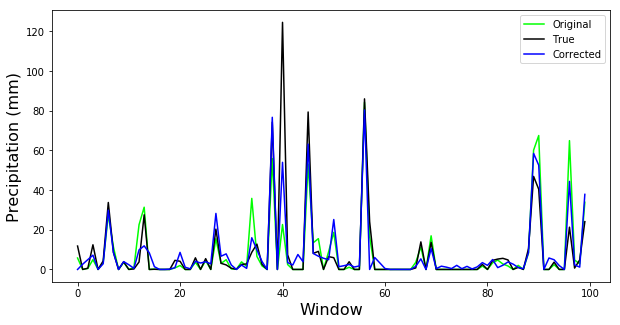

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(prec_orig_window[0, :100], color='lime', label='Original')
plt.plot(prec_true_window[0, :100], color='black', label='True')
plt.plot(prec_corr[:100, 0], color='blue', label='Corrected')
plt.xlabel('Window', fontsize=16)
plt.ylabel('Precipitation (mm)', fontsize=16)
plt.legend()

# Separate training and validation periods

In [68]:
# Divide all windows into training and validation sets (7:3, in order)
n_train = int(n_windows * 0.7)
n_vali = n_windows - n_train
prec_orig_window_train = prec_orig_window[0, :n_train]
prec_orig_window_vali = prec_orig_window[0, n_train:]
prec_true_window_train = prec_true_window[0, :n_train]
prec_true_window_vali = prec_true_window[0, n_train:]
increment_sum_train = increment_sum[:n_train, 0]
increment_sum_vali = increment_sum[n_train:, 0]

# Method 1 - tune lambda to truth (same as in SMART but on training set)

In [80]:
# --- Optimize lambda on the training set --- #
optimized_fraction = scipy.optimize.fminbound(
    func=fraction_tune,
    x1=0.01, x2=2.0,
#    args=(prec_true_window[0, :], prec_orig_window[0, :], increment_sum[:, 0]))
    args=(prec_true_window_train, prec_orig_window_train, increment_sum_train))
print('Optimized fraction: ', optimized_fraction)

Optimized fraction:  0.733730609688


In [86]:
# --- Use lambda to calculate corrected rainfall for training and validation sets --- #
prec_corr_train_method1 = prec_orig_window_train + optimized_fraction * increment_sum_train
prec_corr_train_method1[prec_corr_train_method1<0] = 0
prec_corr_vali_method1 = prec_orig_window_vali + optimized_fraction * increment_sum_vali
prec_corr_vali_method1[prec_corr_vali_method1<0] = 0

In [93]:
# --- Calculate statistics --- #
# RMSE
rmse_orig_train = rmse(prec_orig_window_train, prec_true_window_train)
rmse_corr_train = rmse(prec_corr_train_method1, prec_true_window_train)
rmse_orig_vali = rmse(prec_orig_window_vali, prec_true_window_vali)
rmse_corr_vali = rmse(prec_corr_vali_method1, prec_true_window_vali)
print("Training set: RMSE(orig) = {:.2f}, RMSE(corrected) = {:.2f}".format(
    rmse_orig_train, rmse_corr_train))
print("Validation set: RMSE(orig) = {:.2f}, RMSE(corrected) = {:.2f}".format(
    rmse_orig_vali, rmse_corr_vali))

Training set: RMSE(orig) = 13.66, RMSE(corrected) = 11.55
Validation set: RMSE(orig) = 13.67, RMSE(corrected) = 12.61


In [98]:
# Correlation coefficient
corrcoef_orig_train = np.corrcoef(prec_orig_window_train, prec_true_window_train)[0, 1]
corrcoef_corr_train = np.corrcoef(prec_corr_train_method1, prec_true_window_train)[0, 1]
corrcoef_orig_vali = np.corrcoef(prec_orig_window_vali, prec_true_window_vali)[0, 1]
corrcoef_corr_vali = np.corrcoef(prec_corr_vali_method1, prec_true_window_vali)[0, 1]
print("Training set: corrceof(orig) = {:.2f}, corrceof(corrected) = {:.2f}".format(
    corrcoef_orig_train, corrcoef_corr_train))
print("Validation set: corrcoef(orig) = {:.2f}, corrcoef(corrected) = {:.2f}".format(
    corrcoef_orig_vali, corrcoef_corr_vali))

Training set: corrceof(orig) = 0.76, corrceof(corrected) = 0.84
Validation set: corrcoef(orig) = 0.79, corrcoef(corrected) = 0.83


In [131]:
# RMSE - floods
floods_train = (prec_true_window_train>50)
floods_vali = (prec_true_window_vali>50)
rmse_orig_train = rmse(prec_orig_window_train[floods_train],
                       prec_true_window_train[floods_train])
rmse_corr_train = rmse(prec_corr_train_method1[floods_train],
                       prec_true_window_train[floods_train])
rmse_orig_vali = rmse(prec_orig_window_vali[floods_vali], 
                      prec_true_window_vali[floods_vali])
rmse_corr_vali = rmse(prec_corr_vali_method1[floods_vali],
                      prec_true_window_vali[floods_vali])
print("Floods (true rainfall > 50 mm/window)")
print("Training set: RMSE(orig) = {:.2f}, RMSE(corrected) = {:.2f}".format(
    rmse_orig_train, rmse_corr_train))
print("Validation set: RMSE(orig) = {:.2f}, RMSE(corrected) = {:.2f}".format(
    rmse_orig_vali, rmse_corr_vali))

Floods (true rainfall > 50 mm/window)
Training set: RMSE(orig) = 55.35, RMSE(corrected) = 47.69
Validation set: RMSE(orig) = 50.15, RMSE(corrected) = 48.61


# Method 2 - linear regression of rainfall correction on increment and orig. rainfall

In [148]:
# --- Fit linear regression on the training set --- #
y_train = prec_true_window_train
X_train = np.array([prec_orig_window_train, increment_sum_train]).transpose()
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print('Intercept = {:.2f}'.format(regr.intercept_))
print('Coef. for orig. rainfall = {:.2f}'.format(regr.coef_[0]))
print('Coef. for increment = {:.2f}'.format(regr.coef_[1]))

Intercept = -1.02
Coef. for orig. rainfall = 1.12
Coef. for increment = 0.76


In [149]:
# --- Predict corrected rainfall on both the training and validation sets --- #
prec_corr_train_method2 = regr.predict(X_train)
prec_corr_train_method2[prec_corr_train_method2<0] = 0
X_vali = np.array([prec_orig_window_vali, increment_sum_vali]).transpose()
prec_corr_vali_method2 = regr.predict(X_vali)
prec_corr_vali_method2[prec_corr_vali_method2<0] = 0

In [150]:
# --- Calculate statistics --- #
# RMSE
rmse_orig_train = rmse(prec_orig_window_train, prec_true_window_train)
rmse_corr_train = rmse(prec_corr_train_method2, prec_true_window_train)
rmse_orig_vali = rmse(prec_orig_window_vali, prec_true_window_vali)
rmse_corr_vali = rmse(prec_corr_vali_method2, prec_true_window_vali)
print("Training set: RMSE(orig) = {:.2f}, RMSE(corrected) = {:.2f}".format(
    rmse_orig_train, rmse_corr_train))
print("Validation set: RMSE(orig) = {:.2f}, RMSE(corrected) = {:.2f}".format(
    rmse_orig_vali, rmse_corr_vali))

Training set: RMSE(orig) = 13.66, RMSE(corrected) = 11.34
Validation set: RMSE(orig) = 13.67, RMSE(corrected) = 12.22


In [121]:
# Correlation coefficient
corrcoef_orig_train = np.corrcoef(prec_orig_window_train, prec_true_window_train)[0, 1]
corrcoef_corr_train = np.corrcoef(prec_corr_train_method2, prec_true_window_train)[0, 1]
corrcoef_orig_vali = np.corrcoef(prec_orig_window_vali, prec_true_window_vali)[0, 1]
corrcoef_corr_vali = np.corrcoef(prec_corr_vali_method2, prec_true_window_vali)[0, 1]
print("Training set: corrceof(orig) = {:.2f}, corrceof(corrected) = {:.2f}".format(
    corrcoef_orig_train, corrcoef_corr_train))
print("Validation set: corrcoef(orig) = {:.2f}, corrcoef(corrected) = {:.2f}".format(
    corrcoef_orig_vali, corrcoef_corr_vali))

Training set: corrceof(orig) = 0.76, corrceof(corrected) = 0.84
Validation set: corrcoef(orig) = 0.79, corrcoef(corrected) = 0.83


In [151]:
# RMSE - floods
floods_train = (prec_true_window_train>50)
floods_vali = (prec_true_window_vali>50)
rmse_orig_train = rmse(prec_orig_window_train[floods_train],
                       prec_true_window_train[floods_train])
rmse_corr_train = rmse(prec_corr_train_method2[floods_train],
                       prec_true_window_train[floods_train])
rmse_orig_vali = rmse(prec_orig_window_vali[floods_vali], 
                      prec_true_window_vali[floods_vali])
rmse_corr_vali = rmse(prec_corr_vali_method2[floods_vali],
                      prec_true_window_vali[floods_vali])
print("Floods (true rainfall > 50 mm/window)")
print("Training set: RMSE(orig) = {:.2f}, RMSE(corrected) = {:.2f}".format(
    rmse_orig_train, rmse_corr_train))
print("Validation set: RMSE(orig) = {:.2f}, RMSE(corrected) = {:.2f}".format(
    rmse_orig_vali, rmse_corr_vali))

Floods (true rainfall > 50 mm/window)
Training set: RMSE(orig) = 55.35, RMSE(corrected) = 44.40
Validation set: RMSE(orig) = 50.15, RMSE(corrected) = 46.09


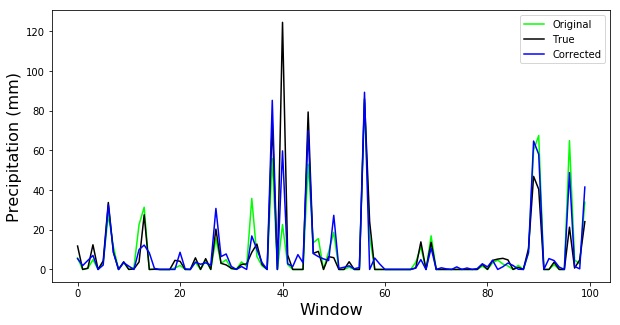

In [119]:
plt.figure(figsize=(10, 5))
plt.plot(prec_orig_window_train[:100], color='lime', label='Original')
plt.plot(prec_true_window_train[:100], color='black', label='True')
plt.plot(prec_corr_train_method2[:100], color='blue', label='Corrected')
plt.xlabel('Window', fontsize=16)
plt.ylabel('Precipitation (mm)', fontsize=16)
plt.legend()

In [112]:
regr.coef_

array([ 1.12410687,  0.75949035])

In [67]:
def fraction_tune(fraction, sum_rain, sum_rain_sp, increment_sum):
    '''This functions calculates the RMS difference between the independent
    rainfall data and the corrected observed rainfall data under a given
    lambda
    Inputs:
        fraction: lambda
        sum_rain: independent rainfall time series for each window (to tune against)
        sum_rain_sp: observed rainfall time series for each window (to correct)
        increment_sum: API increment time series for each window
        NOTE: these three time series must have identical time indices (but need
        not to be continuous)
    Return:
        fraction_fit: RMS difference
    '''

    rain_corrected = sum_rain_sp + (fraction*increment_sum)
    rain_corrected[rain_corrected <= 0] = 0
    fraction_fit = np.sqrt(np.mean((rain_corrected-sum_rain)**2))
    return fraction_fit

In [88]:
def rmse(true, est):
    ''' Calculates RMSE of an estimated variable compared to the truth variable

    Parameters
    ----------
    true: <np.array>
        A 1-D array of time series of true values
    est: <np.array>
        A 1-D array of time series of estimated values (must be the same length of true)

    Returns
    ----------
    rmse: <float>
        Root mean square error

    Require
    ----------
    numpy
    '''

    rmse = np.sqrt(sum((est - true)**2) / len(true))
    return rmse